In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

In [2]:
datadir = '/cellar/users/snwright/Data/NetColocTest/outputs/'
figdir = '/cellar/users/snwright/Data/Transfer/RVC/figures/NetColocTesting/'

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25

In [4]:
go_terms = pd.read_csv('/cellar/users/snwright/Data/NetColocTest/Reference/go.terms.names', sep='\t', index_col=0)

In [5]:
def extract_simulation_parameters(trait_str):
    params = {}
    opts = trait_str.split('_')
    params['trait'] = opts[0]
    params['overlap'] = int(opts[1].split('overlap')[-1])
    params['relevance'] = float(opts[2].split('relevance')[-1])
    params['total_genes'] = int(opts[3].split('totalgenes')[-1])
    params['repeat'] = int(opts[4].split('repeat')[-1])
    params['background'] = opts[5].split('background')[-1]
    return params

def get_param_df(traits):
    param_dict = {}
    for t in traits:
        param_dict[t] = extract_simulation_parameters(t)
    return pd.DataFrame(param_dict).T
    

In [6]:
def load_netcoloc_results(filename):
    results = pd.read_csv(os.path.join(datadir, filename), sep='\t', header=None)
    results.columns = ['TraitR', 'TraitC', 'Network','Mean_NPS', 'Null_mean_NPS', 'P_mean_NPS', 'Size', 'Null_Size', 'P_size' ]
    all_traits = results.TraitR.unique()
    param_df = get_param_df(all_traits)
    results_df = results.join(param_df, on='TraitR').drop(columns=['TraitR', 'TraitC']).join(go_terms, on='trait')
    results_df['logP_mean_NPS'] = -1 * np.log10(results_df['P_mean_NPS']+1e-250)
    results_df['logP_size'] = -1 * np.log10(results_df['P_size']+1e-250)
    results_df['SizeOE'] = results_df['Size']/results_df['Null_Size']
    results_df['NPSdiff'] = results_df['Mean_NPS'] - results_df['Null_mean_NPS']
    return results_df

In [7]:
def plot_by_branch(results_df, xcol='overlap', ycol='Mean_NPS', **kwargs):
    _, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(6, 2), sharex=True, sharey=True)
    sns.lineplot(results_df[results_df.branch=='BP'], x = xcol, y = ycol,  legend=False, ax=ax1, zorder=1, linewidth=0.4, **kwargs)
    sns.scatterplot(results_df[results_df.branch=='BP'], x = xcol, y = ycol,  ax=ax1,legend=False, zorder=2, s=10, **kwargs)
    sns.lineplot(results_df[results_df.branch=='CC'], x = xcol, y = ycol,  legend=False, ax=ax2, linewidth=0.4, **kwargs)
    sns.scatterplot(results_df[results_df.branch=='CC'], x = xcol, y = ycol,  legend=False, ax=ax2, s=10, **kwargs)
    sns.lineplot(results_df[results_df.branch=='MF'],x = xcol, y = ycol, legend=False, ax=ax3, linewidth=0.4, **kwargs)
    sns.scatterplot(results_df[results_df.branch=='MF'],x = xcol, y = ycol, legend=False, ax=ax3, s=10, **kwargs)
    ax1.set_title('BP')
    ax2.set_title('CC')
    ax3.set_title('MF')
    
def plot_by_branch_box(results_df, xcol='overlap', ycol='Mean_NPS', **kwargs):
    _, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(6, 2), sharex=True, sharey=True)
    sns.boxplot(results_df[results_df.branch=='BP'], x = xcol, y = ycol,  ax=ax1,legend=False, zorder=2, **kwargs)
    sns.boxplot(results_df[results_df.branch=='CC'], x = xcol, y = ycol,  legend=False, ax=ax2,**kwargs)
    sns.boxplot(results_df[results_df.branch=='MF'],x = xcol, y = ycol, legend=False, ax=ax3, **kwargs)
    ax1.set_title('BP')
    ax2.set_title('CC')
    ax3.set_title('MF')

In [8]:
def get_overall_trend(data, dependent_variable, independent_variable):
    # Assuming the data has columns 'alpha', 'gene_set', and 'measured_result'
    grouped_data = data.groupby(independent_variable)[dependent_variable].mean().reset_index()

    # Perform correlation and regression on the averaged data
    corr, _ = pearsonr(grouped_data[independent_variable], grouped_data[dependent_variable])
    print(f'Correlation coefficient (averaged): {corr}')

    X = grouped_data[independent_variable].values.reshape(-1, 1)
    y = grouped_data[dependent_variable].values
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    print(f'Linear regression equation (averaged): {dependent_variable} = {slope:.4f} * {independent_variable} + {intercept:.4f}')
    
def get_individual_trends(data, dependent_variable, independent_variable, group_variable='trait'):
    # drop any group_variables with less than 3 data points
    group_counts = data[group_variable].value_counts()
    drop_ids = list(group_counts[group_counts < 3].index)
    data = data[~data[group_variable].isin(drop_ids)]
    
    gene_set_correlations = data.groupby(group_variable).apply(lambda x: pearsonr(x[independent_variable], x[dependent_variable])[0], include_groups=False)
    average_correlation = gene_set_correlations.mean()
    print(f'Average correlation across gene sets: {average_correlation}')
    print(gene_set_correlations.describe(percentiles=[]))

    return gene_set_correlations



## GO Overlap Only
### Remove

In [9]:
overlap_remove = load_netcoloc_results('overlap_only_remove.txt')

In [10]:
overlap_remove.head()

,Network,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,P_size,trait,overlap,relevance,total_genes,repeat,background,name,branch,logP_mean_NPS,logP_size,SizeOE,NPSdiff
0,pcnet2_0,1.003161,0.000330,0.0,938,366.589,1.239000e-259,GO:0000082,0,1.0,150,1,0,G1/S transition of mitotic cell cycle,BP,250.0,250.0,2.558724,1.002831
1,pcnet2_0,1.918688,0.016624,0.0,1695,410.745,0.000000e+00,GO:0000082,100,1.0,150,1,0,G1/S transition of mitotic cell cycle,BP,250.0,250.0,4.126648,1.902064
2,pcnet2_0,1.156335,0.000191,0.0,1130,391.582,0.000000e+00,GO:0000082,10,1.0,150,1,0,G1/S transition of mitotic cell cycle,BP,250.0,250.0,2.885730,1.156143
3,pcnet2_0,2.310791,0.029846,0.0,1957,443.167,0.000000e+00,GO:0000082,130,1.0,150,1,0,G1/S transition of mitotic cell cycle,BP,250.0,250.0,4.415943,2.280945
4,pcnet2_0,1.282079,0.001417,0.0,1177,384.302,0.000000e+00,GO:0000082,20,1.0,150,1,0,G1/S transition of mitotic cell cycle,BP,250.0,250.0,3.062695,1.280662


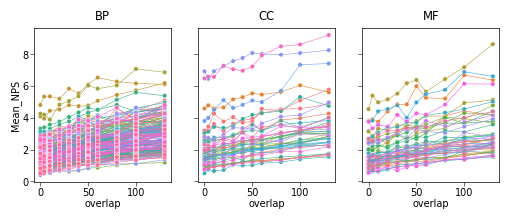

In [11]:
plot_by_branch(overlap_remove, 'overlap', 'Mean_NPS', hue='trait')
plt.savefig(os.path.join(figdir, 'overlap_remove_mean_nps.png'), dpi=300, bbox_inches='tight')

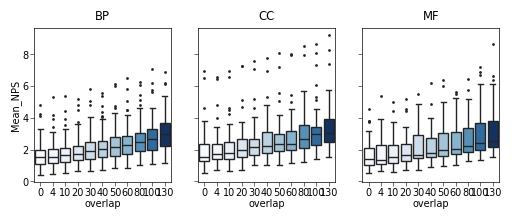

In [12]:
plot_by_branch_box(overlap_remove, 'overlap', 'Mean_NPS', hue='overlap', palette='Blues', fliersize=1)

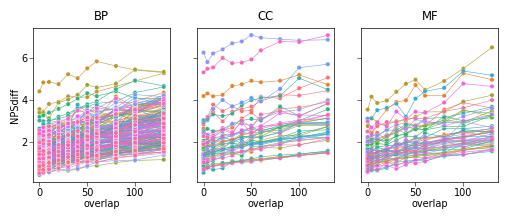

In [13]:
plot_by_branch(overlap_remove, 'overlap', 'NPSdiff', hue='trait')
plt.savefig(os.path.join(figdir, 'overlap_remove_nps_diff.png'), dpi=300, bbox_inches='tight')

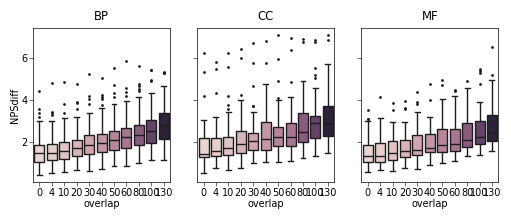

In [14]:
plot_by_branch_box(overlap_remove, 'overlap', 'NPSdiff', fliersize=1, hue='overlap')


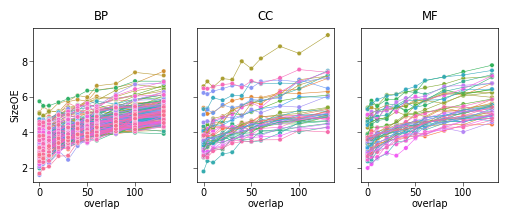

In [15]:
plot_by_branch(overlap_remove, 'overlap', 'SizeOE', hue='trait')
plt.savefig(os.path.join(figdir, 'overlap_remove_sizeOE.png'), dpi=300, bbox_inches='tight')

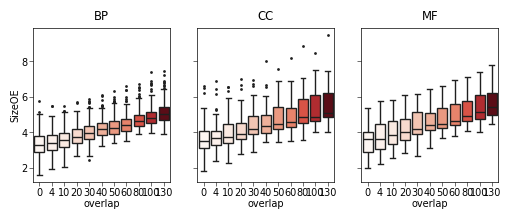

In [16]:
plot_by_branch_box(overlap_remove, 'overlap', 'SizeOE', fliersize=1, hue='overlap', palette='Reds')

In [17]:
overlap_remove.logP_size.describe()

count    3207.000000
mean      248.141411
std        14.401764
min        24.791021
25%       250.000000
50%       250.000000
75%       250.000000
max       250.000000
Name: logP_size, dtype: float64

### Bin

In [18]:
overlap_bin = load_netcoloc_results('overlap_only_bin.txt')

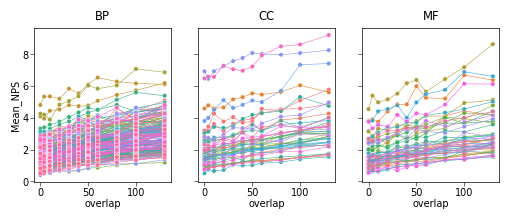

In [19]:
plot_by_branch(overlap_bin, 'overlap', 'Mean_NPS', hue='trait')
plt.savefig(os.path.join(figdir, 'overlap_bin_mean_NPS.png'), dpi=300, bbox_inches='tight')

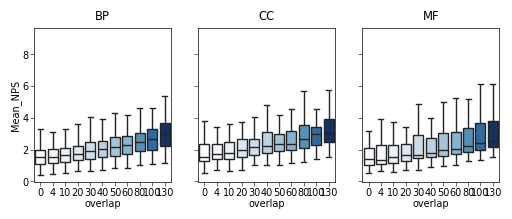

In [20]:
plot_by_branch_box(overlap_bin, 'overlap', 'Mean_NPS', hue='overlap', palette='Blues', fliersize=0)

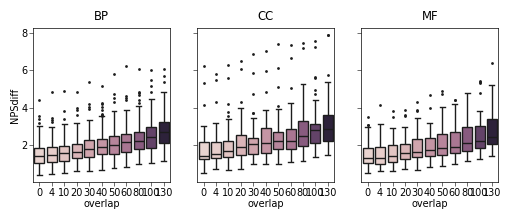

In [21]:
plot_by_branch_box(overlap_bin, 'overlap', 'NPSdiff', fliersize=1, hue='overlap')


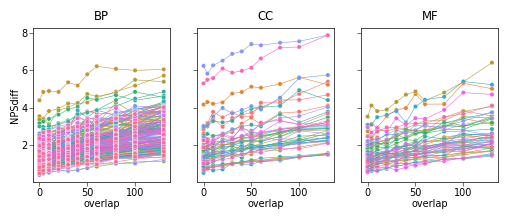

In [22]:
plot_by_branch(overlap_bin, 'overlap', 'NPSdiff',hue='trait')
plt.savefig(os.path.join(figdir, 'overlap_bin_NPS_diff.png'), dpi=300, bbox_inches='tight')

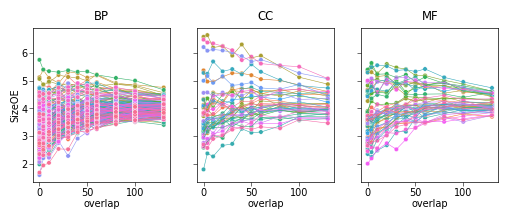

In [23]:
plot_by_branch(overlap_bin, 'overlap', 'SizeOE', hue='trait')
plt.savefig(os.path.join(figdir, 'overlap_bin_size_OE.png'), dpi=300, bbox_inches='tight')

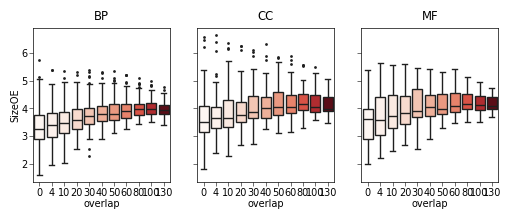

In [24]:
plot_by_branch_box(overlap_bin, 'overlap', 'SizeOE', fliersize=1, hue='overlap', palette='Reds')

In [25]:
overlap_bin.describe()

,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,P_size,logP_mean_NPS,logP_size,SizeOE,NPSdiff
count,3212.000000,3212.000000,3.212000e+03,3212.000000,3212.000000,3.209000e+03,3212.000000,3209.000000,3212.000000,3212.000000
mean,2.276493,0.199569,2.541719e-107,1455.991905,380.414775,2.482082e-30,249.742275,248.149480,3.860462,2.076925
std,1.118852,0.226607,1.025542e-105,356.589156,88.513488,1.406051e-28,4.773839,14.295186,0.607152,0.946352
min,0.404335,-0.110802,0.000000e+00,385.000000,128.250000,0.000000e+00,103.340559,26.098814,1.589294,0.403908
25%,1.514144,0.061478,0.000000e+00,1201.000000,321.779750,0.000000e+00,250.000000,250.000000,3.523481,1.428474
50%,2.050862,0.131055,0.000000e+00,1449.500000,375.933000,0.000000e+00,250.000000,250.000000,3.852782,1.908487
75%,2.787972,0.245144,0.000000e+00,1718.000000,438.261750,0.000000e+00,250.000000,250.000000,4.156012,2.526199
max,9.219624,2.246474,4.565000e-104,2557.000000,726.032000,7.965000e-27,250.000000,250.000000,6.652869,7.876798


### Compare bin & remove

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

def get_overall_trend(data, dependent_variable, independent_variable):
    # Assuming the data has columns 'alpha', 'gene_set', and 'measured_result'
    grouped_data = data.groupby(independent_variable)[dependent_variable].mean().reset_index()

    # Perform correlation and regression on the averaged data
    corr, _ = pearsonr(grouped_data[independent_variable], grouped_data[dependent_variable])
    print(f'Correlation coefficient (averaged): {corr}')

    X = grouped_data[independent_variable].values.reshape(-1, 1)
    y = grouped_data[dependent_variable].values
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    print(f'Linear regression equation (averaged): {dependent_variable} = {slope:.4f} * {independent_variable} + {intercept:.4f}')
    
    return grouped_data, slope, intercept, corr

def plot_trend_with_fit(data, dependent_variable, independent_variable, ax=None):
    grouped_data, slope, intercept, corr = get_overall_trend(data, dependent_variable, independent_variable)
    
    # Scatter plot of the data
    if ax is None:
        plt.figure(figsize=(3, 3))
        ax = plt.gca()
    
    sns.scatterplot(x=grouped_data[independent_variable], y=grouped_data[dependent_variable], color='blue', label='Data', ax=ax)
    
    # Line plot of the fit line
    X = grouped_data[independent_variable].values
    y_fit = slope * X + intercept
    ax.plot(X, y_fit, color='red', label=f'Fit: y = {slope:.4f}x + {intercept:.4f}')
    
    # Annotate the correlation coefficient
    ax.text(0.05, 0.95, f'Correlation: {corr:.4f}', transform=ax.transAxes, fontsize=7, verticalalignment='top')
    
    # Titles and labels
    ax.set_xlabel(independent_variable)
    ax.set_ylabel(dependent_variable)
    ax.legend(loc='lower right')


Correlation coefficient (averaged): 0.9946063843180095
Linear regression equation (averaged): Mean_NPS = 0.0113 * overlap + 1.7364
Correlation coefficient (averaged): 0.992583746306428
Linear regression equation (averaged): NPSdiff = 0.0100 * overlap + 1.6134
Correlation coefficient (averaged): 0.9772314086564682
Linear regression equation (averaged): SizeOE = 0.0142 * overlap + 3.6444


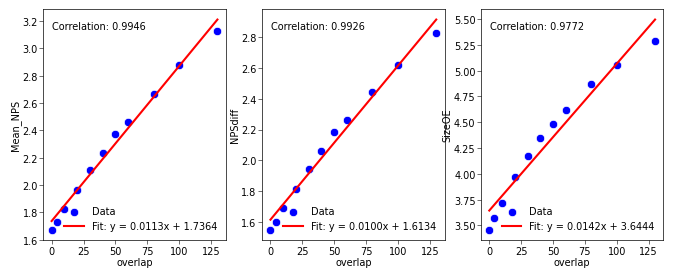

In [27]:
_, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))
plot_trend_with_fit(overlap_remove, 'Mean_NPS', 'overlap', ax=ax1)
plot_trend_with_fit(overlap_remove, 'NPSdiff', 'overlap', ax=ax2)
plot_trend_with_fit(overlap_remove, 'SizeOE', 'overlap', ax=ax3)
plt.savefig(os.path.join(figdir, 'overlap_remove_overlap_correlations.png'), dpi=300, bbox_inches='tight')

Correlation coefficient (averaged): 0.9946063843180095
Linear regression equation (averaged): Mean_NPS = 0.0113 * overlap + 1.7364
Correlation coefficient (averaged): 0.9934056856662403
Linear regression equation (averaged): NPSdiff = 0.0099 * overlap + 1.6076
Correlation coefficient (averaged): 0.8300214567962579
Linear regression equation (averaged): SizeOE = 0.0045 * overlap + 3.6475


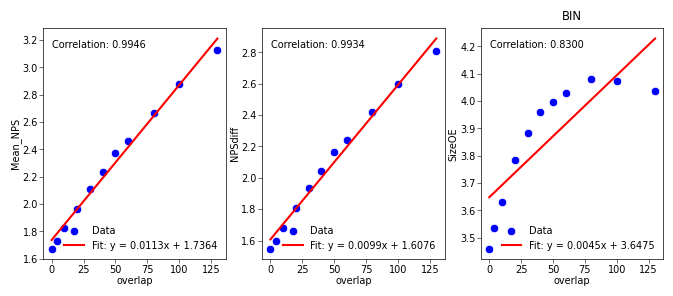

In [28]:
_, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))
plot_trend_with_fit(overlap_bin, 'Mean_NPS', 'overlap', ax=ax1)
plot_trend_with_fit(overlap_bin, 'NPSdiff', 'overlap', ax=ax2)
plot_trend_with_fit(overlap_bin, 'SizeOE', 'overlap', ax=ax3)
plt.title('BIN')
plt.savefig(os.path.join(figdir, 'overlap_bin_overlap_correlations.png'), dpi=300, bbox_inches='tight')

In [29]:
corrs = get_individual_trends(overlap_remove,'SizeOE', 'overlap' )

Average correlation across gene sets: 0.9475099303580768
count    292.000000
mean       0.947510
std        0.025047
min        0.819485
50%        0.952465
max        0.991531
dtype: float64


In [30]:
corrs = get_individual_trends(overlap_bin,'SizeOE', 'overlap' )

Average correlation across gene sets: 0.5694410493597275
count    292.000000
mean       0.569441
std        0.471405
min       -0.987257
50%        0.781081
max        0.949922
dtype: float64


In [31]:
overlap_bin.describe()

,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,P_size,logP_mean_NPS,logP_size,SizeOE,NPSdiff
count,3212.000000,3212.000000,3.212000e+03,3212.000000,3212.000000,3.209000e+03,3212.000000,3209.000000,3212.000000,3212.000000
mean,2.276493,0.199569,2.541719e-107,1455.991905,380.414775,2.482082e-30,249.742275,248.149480,3.860462,2.076925
std,1.118852,0.226607,1.025542e-105,356.589156,88.513488,1.406051e-28,4.773839,14.295186,0.607152,0.946352
min,0.404335,-0.110802,0.000000e+00,385.000000,128.250000,0.000000e+00,103.340559,26.098814,1.589294,0.403908
25%,1.514144,0.061478,0.000000e+00,1201.000000,321.779750,0.000000e+00,250.000000,250.000000,3.523481,1.428474
50%,2.050862,0.131055,0.000000e+00,1449.500000,375.933000,0.000000e+00,250.000000,250.000000,3.852782,1.908487
75%,2.787972,0.245144,0.000000e+00,1718.000000,438.261750,0.000000e+00,250.000000,250.000000,4.156012,2.526199
max,9.219624,2.246474,4.565000e-104,2557.000000,726.032000,7.965000e-27,250.000000,250.000000,6.652869,7.876798


In [32]:
overlap_remove.describe()

,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,P_size,logP_mean_NPS,logP_size,SizeOE,NPSdiff
count,3212.000000,3212.000000,3.211000e+03,3212.000000,3212.000000,3.207000e+03,3211.000000,3207.000000,3212.000000,3212.000000
mean,2.276493,0.186012,1.421675e-107,1408.355542,332.784219,5.045214e-29,249.759844,248.141411,4.322573,2.090481
std,1.118852,0.244327,8.056022e-106,329.026620,74.291676,2.857124e-27,4.341919,14.401764,0.933679,0.923762
min,0.404335,-0.003537,0.000000e+00,385.000000,108.523000,0.000000e+00,103.340559,24.791021,1.593688,0.403908
25%,1.514144,0.041993,0.000000e+00,1175.750000,288.356250,0.000000e+00,250.000000,250.000000,3.710096,1.447286
50%,2.050862,0.105182,0.000000e+00,1408.000000,335.245500,0.000000e+00,250.000000,250.000000,4.275393,1.928588
75%,2.787972,0.222398,0.000000e+00,1644.000000,380.866500,0.000000e+00,250.000000,250.000000,4.840391,2.551123
max,9.219624,2.165253,4.565000e-104,2427.000000,597.526000,1.618000e-25,250.000000,250.000000,9.480045,7.071320


## Constant set sizes

In [33]:
const_bin = load_netcoloc_results('overlap_constant_bin.txt')
const_remove = load_netcoloc_results('overlap_constant_remove.txt')

In [34]:
c = const_bin.trait.value_counts()
list(c[c <3].index)

['GO:0061014', 'GO:0003730', 'GO:0050779']

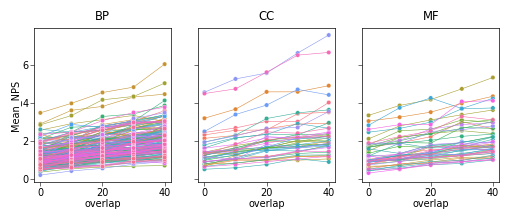

In [35]:
plot_by_branch(const_remove, 'overlap', 'Mean_NPS', hue='trait')

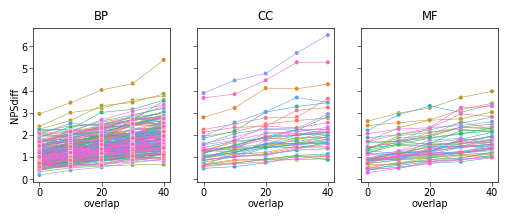

In [36]:
plot_by_branch(const_remove, 'overlap', 'NPSdiff', hue='trait')

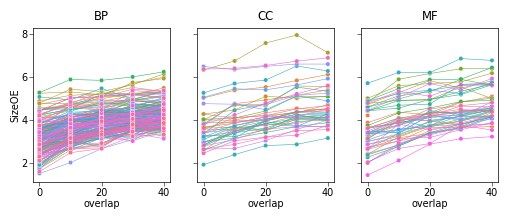

In [37]:
plot_by_branch(const_remove, 'overlap', 'SizeOE', hue='trait')

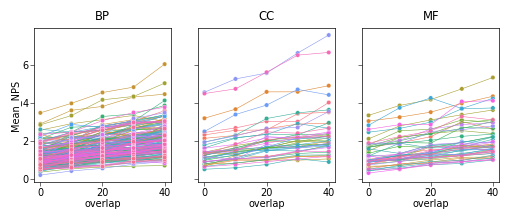

In [38]:
plot_by_branch(const_bin, 'overlap', 'Mean_NPS', hue='trait')

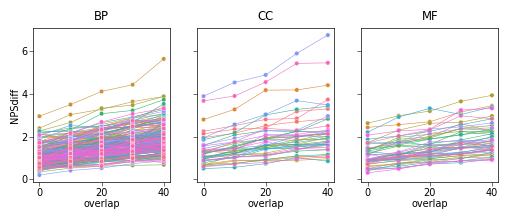

In [39]:
plot_by_branch(const_bin, 'overlap', 'NPSdiff', hue='trait')

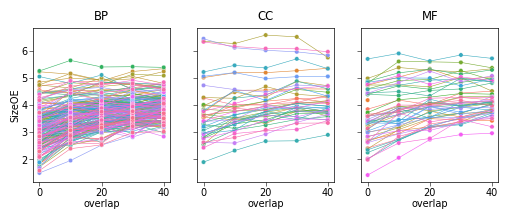

In [40]:
plot_by_branch(const_bin, 'overlap', 'SizeOE', hue='trait')

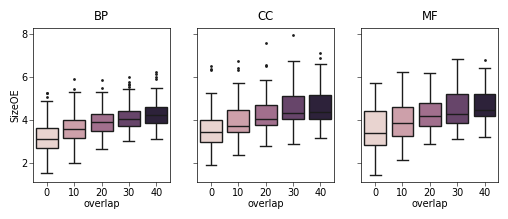

In [41]:
plot_by_branch_box(const_remove, 'overlap', 'SizeOE', hue='overlap', fliersize=1)

In [42]:
get_overall_trend(const_remove, 'SizeOE', 'overlap')

Correlation coefficient (averaged): 0.9790643636774032
Linear regression equation (averaged): SizeOE = 0.0274 * overlap + 3.3911


(   overlap    SizeOE
 0        0  3.285487
 1       10  3.737427
 2       20  4.022305
 3       30  4.246969
 4       40  4.398287,
 0.027351419064094877,
 3.391066655012724,
 0.9790643636774032)

In [43]:
get_overall_trend(const_bin, 'SizeOE', 'overlap')

Correlation coefficient (averaged): 0.9482487021062818
Linear regression equation (averaged): SizeOE = 0.0173 * overlap + 3.3935


(   overlap    SizeOE
 0        0  3.285542
 1       10  3.641739
 2       20  3.824484
 3       30  3.945345
 4       40  3.997084,
 0.017266884009900917,
 3.393501143169683,
 0.9482487021062818)

In [44]:
corrs = get_individual_trends(const_bin,'SizeOE', 'overlap', 'trait')

Average correlation across gene sets: 0.76517729509805
count    293.000000
mean       0.765177
std        0.302045
min       -0.952963
50%        0.866003
max        0.998820
dtype: float64


In [45]:
corrs = get_individual_trends(const_remove,'SizeOE', 'overlap', 'trait')

Average correlation across gene sets: 0.9082571350932511
count    293.000000
mean       0.908257
std        0.084639
min        0.348900
50%        0.932174
max        0.998954
dtype: float64


## N repeats

In [46]:
repeats = load_netcoloc_results('repeat_test.txt')
repeats_r1 = repeats[repeats.relevance==1]

In [47]:
def plot_cvs(data, metric, group_by=['trait','overlap'], ax=None, **kwargs):
    vals = data.groupby(group_by).agg({metric: ['mean', 'std', cv]})
    data_reset = vals.reset_index()
    data_reset.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data_reset.columns.values]
    
    sns.boxplot(data_reset, x='overlap_', y=metric+'_cv', zorder=1, fill=False, fliersize=0, linewidth=0.5,color='grey', ax=ax, **kwargs)
    sns.pointplot(data_reset, x='overlap_', y=metric+'_cv', hue='trait_', zorder=2, linestyle='none', legend=False,ax=ax, 
                    alpha=0.5, markersize=5, **kwargs)
    ax.set_ylim(0, data_reset[metric+'_cv'].max()*1.1)
    

def cv(x):
    return np.std(x)/np.mean(x)

(1.0, 6.0)

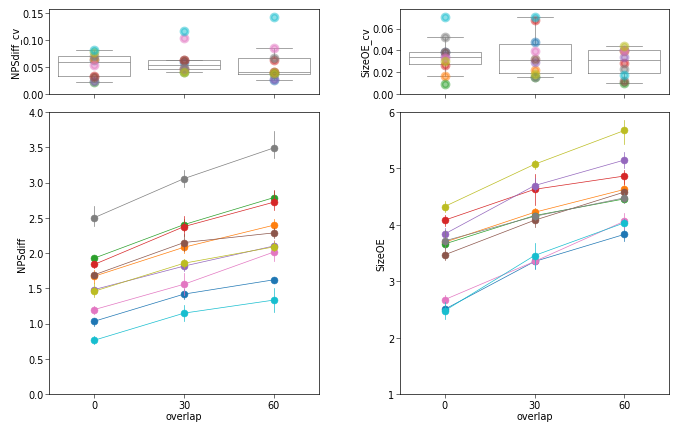

In [48]:
_, [[ax3, ax4], [ax1, ax2]] = plt.subplots(nrows=2, ncols=2, figsize=(8, 5), sharex=True, gridspec_kw={'height_ratios':[0.3, 1], 'hspace':0.1, 'wspace':0.3})
sns.pointplot(repeats_r1, x='overlap', y='NPSdiff', hue='trait', ax=ax1, zorder=2, legend=False, linewidth=0.5, markersize=5)
#sns.lineplot(repeats_r1, x='overlap', y='NPSdiff', hue='trait',zorder=1, ax=ax1, legend=False, linewidth=0.5)
sns.pointplot(repeats_r1, x='overlap', y='SizeOE', hue='trait', ax=ax2, zorder=2, legend=False, linewidth=0.5, markersize=5)
#sns.lineplot(repeats_r1, x='overlap', y='SizeOE', hue='trait',zorder=1, ax=ax2, legend=False, linewidth=0.5)
plot_cvs(repeats_r1, 'NPSdiff', ax=ax3)
plot_cvs(repeats_r1, 'SizeOE', ax=ax4)
ax1.set_ylim(0, 4)
ax2.set_ylim(1, 6)


In [49]:
# what is the confidence on the correlation? 
gene_set_correlations = repeats_r1.groupby(['trait', 'repeat']).apply(lambda x: pearsonr(x['overlap'], x['NPSdiff'])[0], include_groups=False)
gene_set_correlations.groupby('trait').std()

trait
GO:0000082    0.015033
GO:0001704    0.026345
GO:0001935    0.015693
GO:0002699    0.075670
GO:0042445    0.019197
GO:0045216    0.066693
GO:0090068    0.044183
GO:0097529    0.029866
GO:0098742    0.024913
GO:2001234    0.081127
dtype: float64

In [50]:
gene_set_correlations = repeats_r1.groupby(['trait', 'repeat']).apply(lambda x: pearsonr(x['overlap'], x['SizeOE'])[0], include_groups=False)
gene_set_correlations.groupby('trait').std()

trait
GO:0000082    0.018919
GO:0001704    0.020391
GO:0001935    0.014975
GO:0002699    0.097976
GO:0042445    0.025755
GO:0045216    0.021109
GO:0090068    0.006894
GO:0097529    0.068979
GO:0098742    0.055257
GO:2001234    0.022174
dtype: float64

## Disgen Overlap Only

## Compare overlap handling methods

## GO Relevance

In [51]:
rel_df = load_netcoloc_results('all_relevance_only.txt')

In [52]:
add_relevance = overlap_remove[(overlap_remove['overlap']==0) & (overlap_remove['repeat']==1)]

In [53]:
rel_df = pd.concat([rel_df, add_relevance]).reset_index()

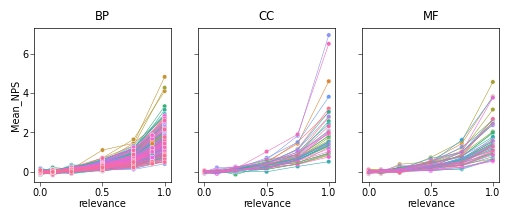

In [73]:
plot_by_branch(rel_df, 'relevance', 'Mean_NPS', hue='trait')

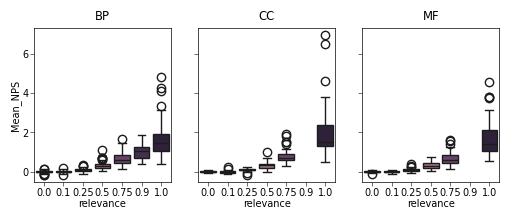

In [55]:
plot_by_branch_box(rel_df, 'relevance', 'Mean_NPS', hue='relevance')

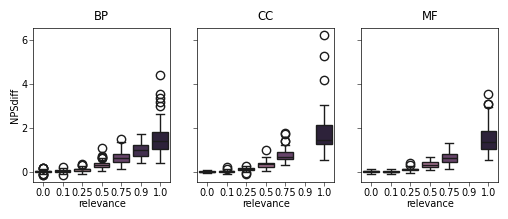

In [56]:
plot_by_branch_box(rel_df, 'relevance', 'NPSdiff', hue='relevance')

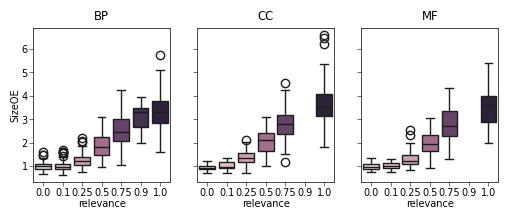

In [57]:
plot_by_branch_box(rel_df, 'relevance', 'SizeOE', hue='relevance')

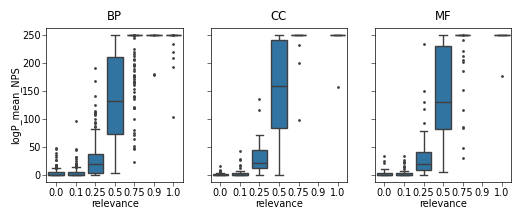

In [58]:
plot_by_branch_box(rel_df, 'relevance', 'logP_mean_NPS', fliersize=1)

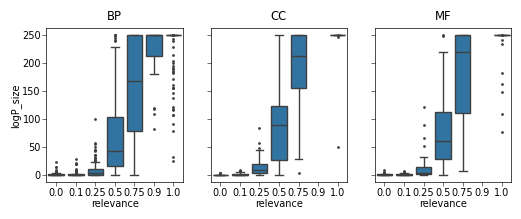

In [59]:
plot_by_branch_box(rel_df, 'relevance', 'logP_size', fliersize=1)

## Disgen Relevance

## Cross-term results

In [60]:
cross_go = pd.read_csv('/cellar/users/snwright/Data/NetColocTest/outputs/cross_go_results.txt', sep='\t', header=None)
cross_go.columns = ['TraitR', 'TraitC', 'Network','Mean_NPS', 'Null_mean_NPS', 'P_mean_NPS', 'Size', 'Null_Size', 'P_size' ]
cross_go['SizeOE'] = cross_go['Size'] / cross_go['Null_Size']
cross_go['NPSdiff'] = cross_go['Mean_NPS'] - cross_go['Null_mean_NPS']

In [61]:
cross_go['logP_mean_NPS'] = -1 * np.log10(cross_go['P_mean_NPS']+1e-250)
cross_go['logP_size'] = -1 * np.log10(cross_go['P_size']+1e-250)

In [62]:
cross_go.sort_values(by='logP_mean_NPS', ascending=False)

,TraitR,TraitC,Network,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,P_size,SizeOE,NPSdiff,logP_mean_NPS,logP_size
203,GO:0051091,GO:0022408,pcnet2_0,1.643124,0.063257,0.000000e+00,1179,418.254,0.000000e+00,2.818861,1.579867,250.0,250.000000
222,GO:0060560,GO:0015081,pcnet2_0,0.831749,0.066750,0.000000e+00,589,321.864,1.378000e-62,1.829965,0.764999,250.0,61.860751
57,GO:0005802,GO:0019722,pcnet2_0,0.574380,0.023430,2.092000e-305,421,340.134,1.934000e-07,1.237747,0.550950,250.0,6.713544
219,GO:0055037,GO:0043123,pcnet2_0,0.847733,0.063853,1.385000e-264,494,334.767,6.352000e-22,1.475653,0.783880,250.0,21.197090
220,GO:0060541,GO:0009743,pcnet2_0,0.985986,0.020508,0.000000e+00,875,390.222,2.156000e-182,2.242313,0.965478,250.0,181.666351
...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,GO:0050920,GO:0006352,pcnet2_0,-0.573668,0.105490,1.000000e+00,202,405.937,1.000000e+00,0.497614,-0.679158,-0.0,-0.000000
117,GO:0017171,GO:0031267,pcnet2_0,-0.147551,0.074211,1.000000e+00,115,258.593,1.000000e+00,0.444714,-0.221762,-0.0,-0.000000
197,GO:0050779,GO:0071222,pcnet2_0,-0.231442,0.139842,1.000000e+00,160,271.262,1.000000e+00,0.589836,-0.371284,-0.0,-0.000000
74,GO:0007033,GO:0097529,pcnet2_0,-0.011099,0.126741,1.000000e+00,171,336.919,1.000000e+00,0.507540,-0.137840,-0.0,-0.000000


<Axes: xlabel='logP_size', ylabel='Count'>

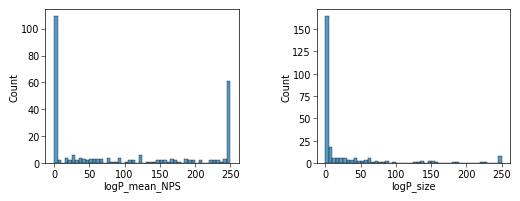

In [63]:
_, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(6, 2), gridspec_kw={'wspace':0.4})
sns.histplot(cross_go.logP_mean_NPS, bins=50, ax=ax1)
sns.histplot(cross_go.logP_size, bins=50, ax=ax2)

In [64]:
gene_df = pd.read_csv('/cellar/users/snwright/Data/NetColocTest/outputs/gene_overlap_cross_trait.txt',sep='\t', header=None)
gene_df.columns = ['TraitPair', 'params', 'Size1', 'Size2', 'Gene_Overlap', 'Gene_Background', 'P-value']

In [65]:
gene_df['Trait1'] = gene_df.TraitPair.apply(lambda x: x.split('_')[0])
gene_df['Trait2'] = gene_df.TraitPair.apply(lambda x: x.split('_')[1])

In [66]:
gene_df.head()

,TraitPair,params,Size1,Size2,Gene_Overlap,Gene_Background,P-value,Trait1,Trait2
0,GO:0000082_GO:0006403,defaults,50,50,0,20000,0.117777,GO:0000082,GO:0006403
1,GO:0000082_GO:1901136,defaults,50,50,0,20000,0.117777,GO:0000082,GO:1901136
2,GO:0000209_GO:0009636,defaults,50,50,1,20000,0.006950,GO:0000209,GO:0009636
3,GO:0000209_GO:0090068,defaults,50,50,1,20000,0.006950,GO:0000209,GO:0090068
4,GO:0000287_GO:0015081,defaults,50,50,1,20000,0.006950,GO:0000287,GO:0015081


In [67]:
all_cross = cross_go.merge(gene_df, left_on=['TraitR', 'TraitC'], right_on=['Trait1', 'Trait2'])

In [68]:
all_cross.head()

,TraitR,TraitC,Network,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,P_size,SizeOE,...,logP_size,TraitPair,params,Size1,Size2,Gene_Overlap,Gene_Background,P-value,Trait1,Trait2
0,GO:0000082,GO:0006403,pcnet2_0,0.555461,0.011314,2.681000e-157,556,310.941,2.187000e-56,1.788121,...,55.660151,GO:0000082_GO:0006403,defaults,50,50,0,20000,0.117777,GO:0000082,GO:0006403
1,GO:0000082,GO:1901136,pcnet2_0,-0.125143,0.003045,1.000000e+00,285,304.250,8.896000e-01,0.936730,...,0.050805,GO:0000082_GO:1901136,defaults,50,50,0,20000,0.117777,GO:0000082,GO:1901136
2,GO:0000209,GO:0009636,pcnet2_0,-0.299902,0.030713,1.000000e+00,152,261.477,1.000000e+00,0.581313,...,-0.000000,GO:0000209_GO:0009636,defaults,50,50,1,20000,0.006950,GO:0000209,GO:0009636
3,GO:0000209,GO:0090068,pcnet2_0,0.217324,-0.010531,1.597000e-45,377,335.057,3.403000e-03,1.125182,...,2.468138,GO:0000209_GO:0090068,defaults,50,50,1,20000,0.006950,GO:0000209,GO:0090068
4,GO:0000287,GO:0015081,pcnet2_0,0.188791,0.037553,3.769000e-29,308,228.859,3.548000e-09,1.345807,...,8.450016,GO:0000287_GO:0015081,defaults,50,50,1,20000,0.006950,GO:0000287,GO:0015081


In [69]:
all_cross.sort_values(by=['logP_size'], ascending=False)

,TraitR,TraitC,Network,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,P_size,SizeOE,...,logP_size,TraitPair,params,Size1,Size2,Gene_Overlap,Gene_Background,P-value,Trait1,Trait2
71,GO:0006909,GO:0050730,pcnet2_0,1.192013,0.059167,0.0,1022,343.335,0.0,2.976685,...,250.0,GO:0006909_GO:0050730,defaults,50,50,1,20000,6.950388e-03,GO:0006909,GO:0050730
49,GO:0005125,GO:0042098,pcnet2_0,2.652528,0.411863,0.0,1033,296.497,0.0,3.484015,...,250.0,GO:0005125_GO:0042098,defaults,100,50,3,20000,1.135719e-04,GO:0005125,GO:0042098
192,GO:0048762,GO:0007179,pcnet2_0,1.236097,0.041921,0.0,1168,376.721,0.0,3.100438,...,250.0,GO:0048762_GO:0007179,defaults,100,100,8,20000,1.768223e-09,GO:0048762,GO:0007179
196,GO:0050730,GO:0006909,pcnet2_0,2.593735,0.155052,0.0,1265,489.166,0.0,2.586034,...,250.0,GO:0050730_GO:0006909,defaults,100,100,4,20000,1.460794e-04,GO:0050730,GO:0006909
155,GO:0042098,GO:0005125,pcnet2_0,2.543604,0.311711,0.0,1125,304.193,0.0,3.698310,...,250.0,GO:0042098_GO:0005125,defaults,100,50,3,20000,1.135719e-04,GO:0042098,GO:0005125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,GO:0033044,GO:0046943,pcnet2_0,-0.645368,0.152729,1.0,87,308.261,1.0,0.282228,...,-0.0,GO:0033044_GO:0046943,defaults,50,50,0,20000,1.177769e-01,GO:0033044,GO:0046943
41,GO:0004016,GO:0031267,pcnet2_0,-0.001574,0.108744,1.0,157,234.208,1.0,0.670344,...,-0.0,GO:0004016_GO:0031267,defaults,50,50,0,20000,1.177769e-01,GO:0004016,GO:0031267
153,GO:0040029,GO:1902600,pcnet2_0,-0.699977,0.121706,1.0,105,303.404,1.0,0.346073,...,-0.0,GO:0040029_GO:1902600,defaults,50,50,0,20000,1.177769e-01,GO:0040029,GO:1902600
160,GO:0043123,GO:0005681,pcnet2_0,-0.611154,0.078956,1.0,132,315.603,1.0,0.418247,...,-0.0,GO:0043123_GO:0005681,defaults,100,50,0,20000,2.219274e-01,GO:0043123,GO:0005681


In [70]:
all_cross[(all_cross.TraitR.isin(['GO:0006909','GO:0050730'])) & (all_cross.TraitC.isin(['GO:0006909','GO:0050730']))]

,TraitR,TraitC,Network,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,P_size,SizeOE,...,logP_size,TraitPair,params,Size1,Size2,Gene_Overlap,Gene_Background,P-value,Trait1,Trait2
71,GO:0006909,GO:0050730,pcnet2_0,1.192013,0.059167,0.0,1022,343.335,0.0,2.976685,...,250.0,GO:0006909_GO:0050730,defaults,50,50,1,20000,0.006950,GO:0006909,GO:0050730
196,GO:0050730,GO:0006909,pcnet2_0,2.593735,0.155052,0.0,1265,489.166,0.0,2.586034,...,250.0,GO:0050730_GO:0006909,defaults,100,100,4,20000,0.000146,GO:0050730,GO:0006909


<Axes: xlabel='SizeOE', ylabel='Count'>

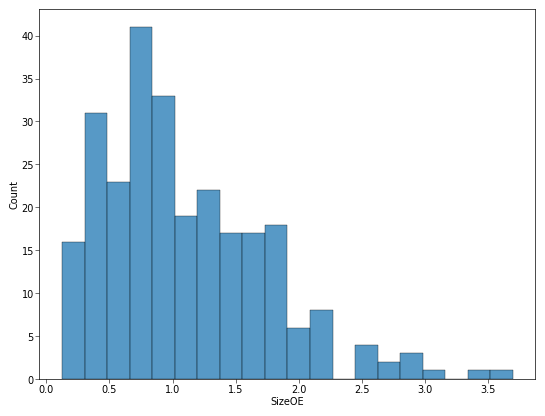

In [71]:
sns.histplot(all_cross.SizeOE, bins=20)

<Axes: xlabel='NPSdiff', ylabel='Count'>

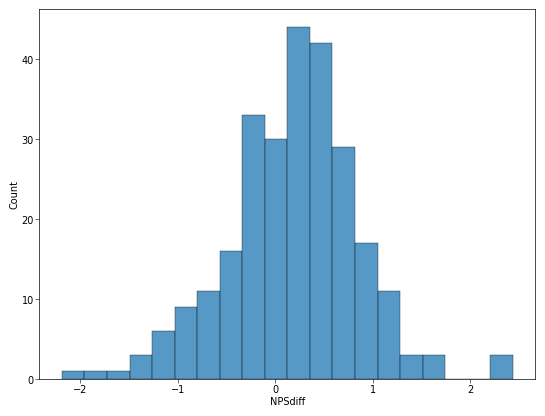

In [72]:
sns.histplot(all_cross.NPSdiff, bins=20)